<a href="https://colab.research.google.com/github/Clemkun/FadillahMurti_UAS_MachineLearning/blob/main/FadillahMurti_UAS_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# --- Analisis KMeans untuk Wholesale customers ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [6]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# 1. Load
path = '/content/drive/MyDrive/uas MP/Wholesale customers data.csv'
df = pd.read_csv(path)

In [8]:
# drop unnamed index if any
unnamed_cols = [c for c in df.columns if 'Unnamed' in c]
if unnamed_cols:
    df = df.drop(columns=unnamed_cols)

In [9]:
# 2. Select numeric spending features (exclude Channel/Region)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in ['Channel', 'Region']:
    if c in numeric_cols:
        numeric_cols.remove(c)
features = numeric_cols

X = df[features].copy()

In [10]:
# 3. Preprocess: log1p + StandardScaler
X_log = np.log1p(X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

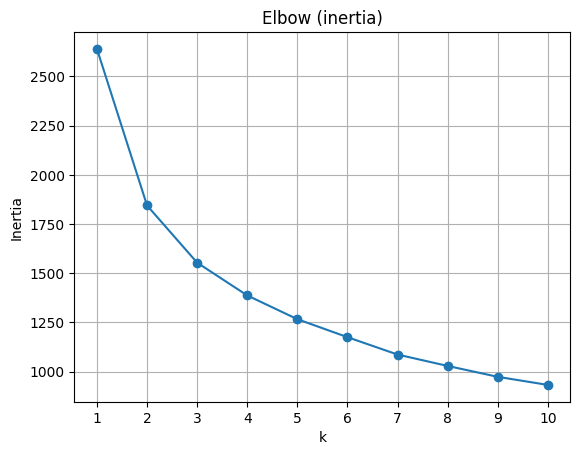

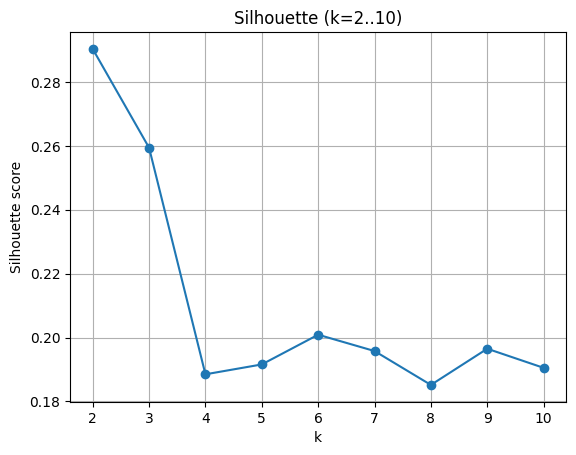

Chosen k: 2


In [11]:
# 4. Evaluate k with Elbow & Silhouette
inertias = []
sil_scores = []
ks = list(range(1, 11))
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

# plot inertia (Elbow)
plt.figure(); plt.plot(ks, inertias, marker='o'); plt.title('Elbow (inertia)'); plt.xlabel('k'); plt.ylabel('Inertia'); plt.xticks(ks); plt.grid(True); plt.show()

# plot silhouette
plt.figure(); plt.plot(list(range(2,11)), sil_scores, marker='o'); plt.title('Silhouette (k=2..10)'); plt.xlabel('k'); plt.ylabel('Silhouette score'); plt.grid(True); plt.show()

# choose k (here: by silhouette)
best_k_by_sil = int(np.argmax(sil_scores) + 2)
chosen_k = best_k_by_sil
print("Chosen k:", chosen_k)

In [12]:
# 5. Fit final KMeans
km_final = KMeans(n_clusters=chosen_k, random_state=42, n_init=50)
labels_final = km_final.fit_predict(X_scaled)
df['cluster'] = labels_final

In [13]:
# 6. Cluster centers back to original scale
centers_scaled = km_final.cluster_centers_
centers_log = scaler.inverse_transform(centers_scaled)
centers_original = np.expm1(centers_log)
centers_df = pd.DataFrame(centers_original, columns=features)
centers_df.index.name = 'cluster'
print("Cluster centers (original scale):")
print(centers_df.round(2))

Cluster centers (original scale):
           Fresh     Milk   Grocery   Frozen  Detergents_Paper  Delicassen
cluster                                                                   
0        8580.59  1753.70   2274.38  2063.83            287.37      649.35
1        4013.88  8061.57  12051.07   953.53           4035.60     1022.09


In [14]:
# 7. Profiling
cluster_profile = df.groupby('cluster')[features].mean().round(2)
cluster_counts = df['cluster'].value_counts().sort_index()
print("Cluster sizes:\n", cluster_counts)
print("Cluster profiling:\n", cluster_profile)

Cluster sizes:
 cluster
0    252
1    188
Name: count, dtype: int64
Cluster profiling:
             Fresh      Milk   Grocery   Frozen  Detergents_Paper  Delicassen
cluster                                                                     
0        13973.13   2401.75   2918.71  3705.67            491.94     1038.04
1         9355.87  10346.36  14697.06  2222.45           6084.51     2177.43


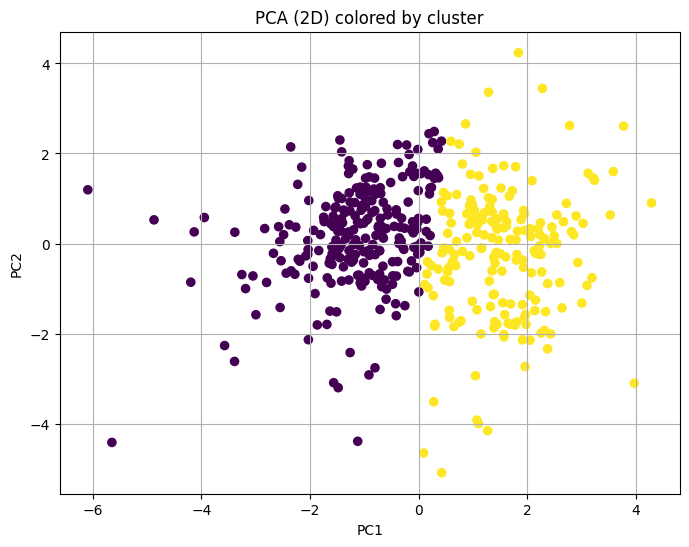

In [15]:
# 8. PCA 2D scatter
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels_final, s=35)
plt.title('PCA (2D) colored by cluster'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.grid(True); plt.show()

In [16]:
# 9. Save results
df.to_csv('/content/Wholesale customers data.csv', index=False)
cluster_profile['count'] = cluster_counts
cluster_profile.to_csv('/content/Wholesale customers data.csv')